<a href="https://colab.research.google.com/github/kaixiu/hedging/blob/master/multi_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt


# from scipy.stats import multivariate_normal
%matplotlib inline
%autosave 0
np.random.seed(1)
tf.set_random_seed(1)

Instructions for updating:
non-resource variables are not supported in the long term
b'Hello, TensorFlow!'


Autosave disabled


In [0]:
def call_delta(s,k,r,sigma,T):
    d1=1/sigma/np.sqrt(T)*(np.log(s/k)+(r+0.5*sigma*sigma)*T)
    return norm.cdf(d1)


In [0]:
def call_price_bs(s,k,r,sigma,T):
    d1=1/sigma/np.sqrt(T)*(np.log(s/k)+(r+0.5*sigma*sigma)*T)
    d2=d1-sigma*np.sqrt(T)
    return s*norm.cdf(d1)-k*np.exp(-r*T)*norm.cdf(d2)


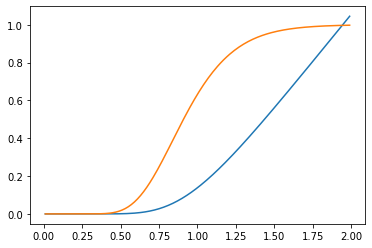

In [0]:
nssample=100
s0=1
k=1
r=0.1/360
sigma=0.02
Texp=200
price=[call_price_bs(s,k,r,sigma,Texp) for s in np.arange(0.01,2,0.01)]
delta=[call_delta(s,k,r,sigma,Texp) for s in np.arange(0.01,2,0.01)]
plt.plot(np.arange(0.01,2,0.01),price)
plt.plot(np.arange(0.01,2,0.01),delta)
plt.show()

In [0]:
nssample=100
s0=1
k=1
r=0.1/360
sigma=0.02
Texp=200
paths=np.vstack([np.array([s0*np.exp(r*t-0.5*sigma*sigma*t+\
                  sigma*np.random.normal()*np.sqrt(t)) for t in range(0,Texp)]) for x in range(nssample)])
pathdiff=np.diff(paths)
times=np.vstack([range(Texp,0,-1) for x in range(nssample)])
paths0=paths[:,1:]
paths1=paths[:,:-1]
times=times[:,1:]

h_prices=np.array([call_price_bs(s,k,r,sigma,t)-0.6*s for s,t in zip(paths0,times)])
prices=np.array([call_price_bs(s,k,r,sigma,t) for s,t in zip(paths0,times)])
deltas=np.array([call_delta(s,k,r,sigma,t) for s,t in zip(paths0,times)])

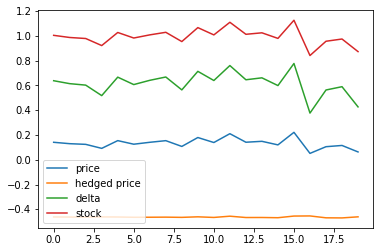

In [0]:
n=10
m=20
plt.plot(prices[n,:m],label="price")
plt.plot(h_prices[n,:m],label="hedged price")
plt.plot(deltas[n,:m],label="delta")
plt.plot(paths0[n,:m],label="stock")
plt.legend(loc="best")
plt.show()

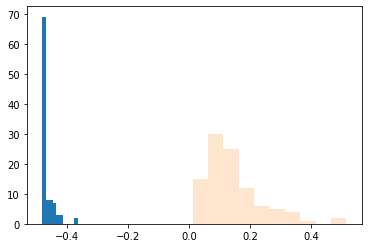

In [0]:
plt.hist(h_prices[:,50])
plt.hist(prices[:,50],alpha=0.2)
plt.show()

In [0]:
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        self.a = self._build_a(self.S,)
        q = self._build_c(self.S, self.a, )
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Critic')
        ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)          # soft replacement

        def ema_getter(getter, name, *args, **kwargs):
            return ema.average(getter(name, *args, **kwargs))

        target_update = [ema.apply(a_params), ema.apply(c_params)]      # soft update operation
        a_ = self._build_a(self.S_, reuse=True, custom_getter=ema_getter)   # replaced target parameters
        q_ = self._build_c(self.S_, a_, reuse=True, custom_getter=ema_getter)

        a_loss = - tf.reduce_mean(q)  # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=a_params)

        with tf.control_dependencies(target_update):    # soft replacement happened at here
            q_target = self.R + GAMMA * q_
            td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=c_params)

        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, reuse=None, custom_getter=None):
        trainable = True if reuse is None else False
        with tf.variable_scope('Actor', reuse=reuse, custom_getter=custom_getter):
            net = tf.layers.dense(s, 30, activation=tf.nn.relu, name='l1', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound, name='scaled_a')

    def _build_c(self, s, a, reuse=None, custom_getter=None):
        trainable = True if reuse is None else False
        with tf.variable_scope('Critic', reuse=reuse, custom_getter=custom_getter):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)



In [0]:
aa=np.random.multivariate_normal(np.zeros(2),[[1,0.8],[0.8,1]] , size=5000)

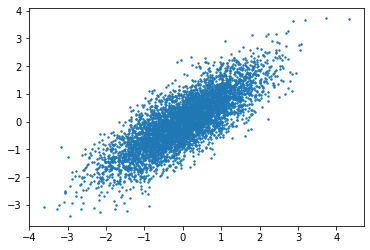

In [0]:
plt.scatter(aa[:,0],aa[:,1],s=2)

In [0]:
np.vstack([np.array([s0*np.exp(r*t-0.5*sigma*sigma*t+\
                  sigma*np.random.normal()*np.sqrt(t)) for t in range(0,Texp)]) for x in range(nssample)])

In [0]:
np.linalg.det([[1,0.5,0.5],[0.5,1,0.5],[0.5,0.5,1]])

0.5000000000000001

In [0]:
aa=np.random.multivariate_normal(np.zeros(3),[[1,0.5,0.5],[0.5,1,0.5],[0.5,0.5,1]] , size=50000)

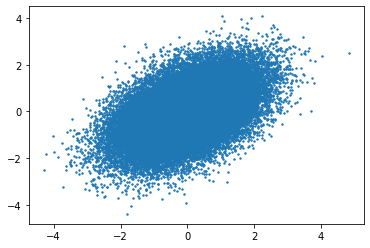

In [0]:
plt.scatter(aa[:,0],aa[:,1],s=2)